<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/EMW_targeted_FGSM_cleverhans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220


In [3]:
print(mods)
mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)

print(snrs)

[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [4]:
# 读取输入并划分训练集和测试集
# np.random.seed(2016)
n_examples = X.shape[0]  # int 162060
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)  # ndarray with shape (81030,)
test_idx = list(set(range(0,n_examples))-set(train_idx))   # list (81030 items total)

X_train = X[train_idx]  # ndarray with shape (81030, 2, 128)
X_test =  X[test_idx]   # 同上
print(X_train.shape)

(81030, 2, 128)


In [220]:
# print(lbl.shape) # AttributeError: 'list' object has no attribute 'shape' 解决办法是使用vstack函数
lbl_no = np.vstack(lbl)  # 这一步骤没必要，因为可以直接使用lbl去取出来调制方式
# print(lbl_no)  # ndarray with shape (162060, 2)  [b'8PSK' b'-20']

lbl_mods = lbl_no[0]
print(lbl_mods)


Y_train_no = list(map(lambda x: mods.index(lbl[x][0]), train_idx))  # 显示的是1-11数字表示调制方式list (81030 items total)
print(Y_train_no[1])
Y_train_mods = np.vstack(Y_train_no)  # # ndarray with shape (81030, 1)

Y_test_no = list(map(lambda x: mods.index(lbl[x][0]), test_idx))  
Y_test_no = np.vstack(Y_test_no) # ndarray with shape (81030, 1)
# print(Y_test_no)

Y_train_mod = lbl_no[:,0]
Y_train_mod_vsatck = np.vstack(Y_train_mod)  # 字幕显示调制方式ndarray with shape (162060, 1)
# print(Y_train_mod_vsatck)

Y_train_snrs = list(map(lambda x: snrs.index(lbl[x][1]), train_idx))
# print(Y_train_snrs)
Y_train_snrs = np.vstack(Y_train_snrs)  
Y_test_snrs = list(map(lambda x: snrs.index(lbl[x][1]), test_idx))
print(Y_test_snrs[1])
Y_test_snrs = np.vstack(Y_test_snrs)  

[b'8PSK' b'-20']
9
5


In [6]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))  # ndarray with shape (81030, 11)

In [7]:
in_shp = list(X_train.shape[1:])   # list [2, 128]

classes = mods  # list [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM'] (11 items total)

mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)   # list ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
# print(Y_train[1])  # [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
# print(Y_train.shape)  # ndarray with shape (81030, 11)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [8]:
num_classes = 11

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=in_shp),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(135,activation=tf.nn.relu),
    tf.keras.layers.Dense(11),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [9]:
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_split=0.2)
# model.fit(X_train, Y_train,  epochs=nb_epoch, verbose=2, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/100
64/64 - 1s - loss: 4.1203 - accuracy: 0.1738 - val_loss: 2.2512 - val_accuracy: 0.1845
Epoch 2/100
64/64 - 0s - loss: 2.2297 - accuracy: 0.1925 - val_loss: 2.1977 - val_accuracy: 0.1897
Epoch 3/100
64/64 - 0s - loss: 2.1766 - accuracy: 0.2132 - val_loss: 2.1505 - val_accuracy: 0.2219
Epoch 4/100
64/64 - 0s - loss: 2.1182 - accuracy: 0.2730 - val_loss: 2.0863 - val_accuracy: 0.3013
Epoch 5/100
64/64 - 0s - loss: 2.0399 - accuracy: 0.2952 - val_loss: 1.9956 - val_accuracy: 0.3052
Epoch 6/100
64/64 - 0s - loss: 1.9438 - accuracy: 0.3047 - val_loss: 1.8825 - val_accuracy: 0.3406
Epoch 7/100
64/64 - 0s - loss: 1.8207 - accuracy: 0.3557 - val_loss: 1.7541 - val_accuracy: 0.3763
Epoch 8/100
64/64 - 0s - loss: 1.7139 - accuracy: 0.3800 - val_loss: 1.6720 - val_accuracy: 0.3963
Epoch 9/100
64/64 - 0s - loss: 1.6419 - accuracy: 0.4027 - val_loss: 1.6098 - val_accuracy: 0.4193
Epoch 10/100
64/64 - 0s - loss: 1.5861 - accuracy: 0.4202 - val_loss: 1.5588 - val_accuracy: 0.4409
Epoch 11/

In [10]:
pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-alzs3hny/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-alzs3hny/cleverhans
     |████████████████████████████████| 163kB 3.1MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=c95094c0b4cc1bbde48f213bd992f73ed313ab0b150e5ef091492498a01eba13
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhpqzcis/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


In [97]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [166]:
random_index = 6000
print("Y_test[random_index]=",Y_test[random_index],"Y_test_no[random_index]=",Y_test_no[random_index],"Y_test_snrs[random_index]=",Y_test_snrs[random_index])

Y_test[random_index]= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Y_test_no[random_index]= [0] Y_test_snrs[random_index]= [15]


In [168]:
# 现在是随机选择一个无线电信号，后面重新固定SNR和调制方式进行选择
# random_index = np.random.randint(X_test.shape[0])
original_image_targeted = X_test[random_index]

original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')
example_targeted_pred = model.predict(original_image) 
print(example_targeted_pred)
#Show the image
# plt.figure()
# plt.grid(False)
original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]
# plt.axis([-1, 1, -1, 1])
# plt.plot(real,label='real')
# plt.plot(imag,label='imag')
# plt.imshow(np.reshape(original_image, (2,128)))
# plt.title("Label: {}".format(original_label[0]))
# plt.legend()  #设置 legend 图例

[[2.6731130e-01 1.6513339e-11 3.3736922e-07 1.4819792e-02 2.5806212e-01
  2.2869710e-05 2.0977047e-06 1.2999048e-04 1.6719554e-04 4.5948428e-01
  3.7509515e-09]]


In [170]:
target = 9
target_label = np.reshape(target, (1,)).astype('int64')

target= 9 epoch= 0 epsilon= 0.05 
 target_fgsm_pred= [[2.39160821e-01 2.80749621e-12 1.08191735e-07 7.67933996e-03
  2.91508678e-02 1.22330721e-06 1.05664162e-06 7.22467448e-05
  5.70527736e-05 7.23877311e-01 2.27708422e-10]]
[0.04999998 0.04999997]


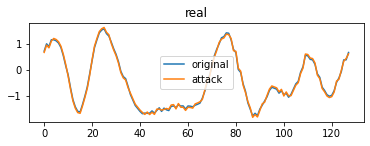

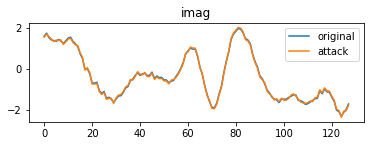

In [172]:
# 定向攻击把FGSM里的参数设置为True即可
# 调用fgsm迭代直到攻击成功为止
epochs = 100

epsilon = 0.05
for epoch in range(epochs):
  target_fgsm = fast_gradient_method(logits_model, original_image, epsilon, np.inf, y=target_label, targeted=True)
  target_fgsm_pred = model.predict(target_fgsm)
  attack = np.argmax(target_fgsm_pred)
  if target == attack:
    #  输出攻击成功的结果
    print("target=",attack,"epoch=",epoch,"epsilon=",epsilon,'\n',"target_fgsm_pred=",target_fgsm_pred)

    target_fgsm_plt = np.reshape(target_fgsm, (2,128))
    real_adv = target_fgsm_plt[0]  #取（2，128）的行
    imag_adv = target_fgsm_plt[1]
    plt.figure()
    # plt.suptitle('mods={},SNR={},attack={}'.format(np.argmax(example_untargeted_pred)),-10dB,np.argmax(adv_example_untargeted_label_pred)))
    plt.subplot(2,1,1)
    plt.plot(real,label='original')
    plt.plot(real_adv,label='attack')
    plt.title("real")
    plt.legend()  #设置 legend 图例
    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(imag,label='original')
    plt.plot(imag_adv,label='attack')
    plt.title("imag")
    plt.legend()  #设置 legend 图例
    # 实虚部的均方根误差
    x1 = original_image_plt
    x2_FGSM = target_fgsm_plt
    x1_2 = x1 - x2_FGSM
    x1_2_2 = np.multiply(x1_2,x1_2)  # 矩阵对应元素相乘就相当于各个元素平方
    x1_2_2_sum = x1_2_2.sum(axis=1)  # axis=1求行和
    x1_2_2_sum_chu = x1_2_2_sum / 128
    x_sqrt = np.sqrt(x1_2_2_sum_chu)
    print(x_sqrt)
    break
  else:
    epsilon = epsilon + 0.05
    print("attack false",epsilon)

下面是为了检查上次BIM中低识别准确率的8PSK信号存在问题：为什么10dB均方误差比-10dB大，但是从图上看反而-10dB下干扰更隐蔽？

In [214]:
random_index = 6000
original_image_targeted = X_test[random_index]

original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')
example_targeted_pred = model.predict(original_image) 
 
original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]

9 [[2.6731130e-01 1.6513339e-11 3.3736922e-07 1.4819792e-02 2.5806212e-01
  2.2869710e-05 2.0977047e-06 1.2999048e-04 1.6719554e-04 4.5948428e-01
  3.7509515e-09]]
4 [[1.1183919e-08 7.3746799e-18 2.7589140e-14 8.6778130e-08 9.9999940e-01
  4.6282705e-07 9.9068228e-15 9.1381987e-14 4.5600015e-13 2.8685885e-09
  3.2392197e-11]]


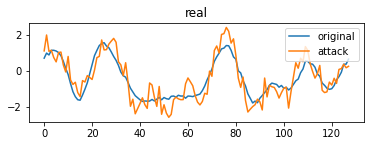

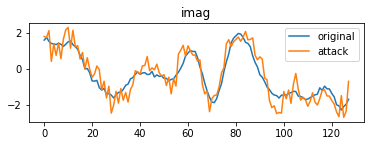

In [215]:
# 参数的设置问题： assert eps_iter <= eps, (eps_iter, eps)会报错，其中assert函数是判断语句
# BIM aT=e
from cleverhans.future.tf2.attacks import basic_iterative_method
from cleverhans.future.tf2.attacks import projected_gradient_descent
epsilon_BIM = 1
eps_iter_BIM = 0.1
nb_iter_BIM = 10

adv_example_untargeted_label_BIM = basic_iterative_method(logits_model, original_image, epsilon_BIM, eps_iter_BIM, nb_iter_BIM, norm=np.inf, 
                        targeted=False, rand_minmax=0.3, sanity_checks=True)  # EagerTensor with shape (1, 2, 128)
example_untargeted_pred = model.predict(original_image) 
adv_example_untargeted_label_pred_BIM  = model.predict(adv_example_untargeted_label_BIM )  # ndarray with shape (1, 11) 给出了11个概率
print(np.argmax(example_untargeted_pred),example_untargeted_pred)
print(np.argmax(adv_example_untargeted_label_pred_BIM ),adv_example_untargeted_label_pred_BIM )

original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]

adv_example_untargeted_label_BIM_plt = np.reshape(adv_example_untargeted_label_BIM , (2,128))
real_adv = adv_example_untargeted_label_BIM_plt[0]  #取（2，128）的行
imag_adv = adv_example_untargeted_label_BIM_plt[1]

plt.figure()
plt.subplot(2,1,1)
plt.plot(real,label='original')
plt.plot(real_adv,label='attack')
plt.title("real")
plt.legend()  #设置 legend 图例
plt.figure()
plt.subplot(2,1,2)
plt.plot(imag,label='original')
plt.plot(imag_adv,label='attack')
plt.title("imag")
plt.legend()  #设置 legend 图例

In [218]:
x1 = original_image_plt
x2_BIM = adv_example_untargeted_label_BIM_plt
x1_2 = x1 - x2_BIM
x1_2_2 = np.multiply(x1_2,x1_2)  # 矩阵对应元素相乘就相当于各个元素平方
x1_2_2_sum = x1_2_2.sum(axis=1)  # axis=1求行和
x1_2_2_sum_chu = x1_2_2_sum / 128
x_sqrt = np.sqrt(x1_2_2_sum_chu)
print(x_sqrt) 

[0.557057   0.53180116]
